Analyze and visualize the provided graph and provide statistics such as, betweenness centrality, average path length and frequency of concept occurrence in different paths.

In [51]:
import time
import itertools
import random
import os
import pickle
import json
import linecache
import numpy as np
import pandas as pd
from scipy import stats

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

### Get Validation Edges

Identifying the Validation Edges, and obtaining the shortest path lengths between these pairs in the Training Graph.

In [5]:
KG = nx.read_gpickle("../training_KG_concepts.gpickle")

In [6]:
edges_cc = pd.read_csv("data/edges_cc.csv")
all_edges = [
    (edges_cc.src[i], edges_cc.dst[i]) \
    for i \
    in range(len(edges_cc))
]

KG = nx.read_gpickle("training_KG_concepts.gpickle")

training_edges = list(KG.edges())
validation_edges = [
    edge \
    for edge \
    in all_edges \
    if edge not in training_edges
]
validation_edges = list(set(all_edges)-set(training_edges))

In [42]:
validation_edge_lengths = []
for edge in validation_edges[-1]:
    try:
        dist = nx.astar_path_length(KG, edge[0], edge[1])
    except:
        continue
    if dist > 1:
        validation_edge_lengths.append((edge[0], edge[1], dist))
with open("validation_edge_lengths.json", "w") as f:
    json.dump(validation_edge_lengths,f)

In [60]:
validation_lengths = [edge[2] for edge in validation_edge_lengths]
validation_lengths_freq = {}
for i in set(validation_lengths):
    validation_lengths_freq[i] = validation_lengths.count(i)/len(validation_lengths)

In [147]:
np.mean(validation_lengths), np.std(validation_lengths)

(2.3628037611429966, 0.5412646288257684)

In [108]:
np.max(validation_lengths)

5

### Shortest Paths

In [43]:
def retrieve_all_paths(node):
    """
    Retrieves all shortest paths from a particular node.
    """
    file_ranges = [
        [int(i) for i in s.split("_")[:2]] \
        for s \
        in os.listdir("shortest_paths")
    ]
    for r in file_ranges:
        if r[0]<=node<=r[1]:
            file = "shortest_paths/%d_%d_lengths.txt"%(r[0], r[1])
            break
    line = node - r[0] + 1
    paths = linecache.getline(
        "shortest_paths/0_1_paths.txt",
        line)
    return [
        [int(j) for j in i[1:].split(", ")] \
        for i \
        in paths[1:-3].split("], ")
    ]

def retrieve_all_lengths(node):
    """
    Retrieves all shortest path lengths from a particular node.
    """
    file_ranges = [
        [int(i) for i in s.split("_")[:2]] \
        for s \
        in os.listdir("shortest_paths")
    ]
    for r in file_ranges:
        if r[0]<=node<=r[1]:
            file = "shortest_paths/%d_%d_lengths.txt"%(r[0], r[1])
            break
    line = node - r[0] + 1
    lengths = linecache.getline(
        file,
        line)
    return [
        int(i) \
        if i != "nan" \
        else np.nan
        for i \
        in lengths[1:-2].split(", ")
    ]

In [49]:
# length_freq = {}
# for node in range(46669):
#     for i in retrieve_all_lengths(node):
#         if i in length_freq:
#             length_freq[i] += 1
#         else:
#             length_freq[i] = 1
# np.save("APL_freq.npy", length_freq) 

In [149]:
training_lengths_freq_normalized = length_freq_normalized

In [35]:
#training_lengths_freq = np.load("APL_freq.npy", allow_pickle=True).item()
training_lengths_freq_normalized = {}
for i in training_lengths_freq:
    training_lengths_freq_normalized[i] = training_lengths_freq[i] \
        /np.sum(list(training_lengths_freq.values()))

In [32]:
training_lengths_freq = {1: 46669,
 4: 1099472818,
 6: 98440552,
 5: 687424310,
 3: 238203722,
 8: 535650,
 7: 7936026,
 2: 600022,
 9: 25196,
 10: 802,
 11: 24}

In [68]:
np.quantile(sample_dict_to_rv(training_lengths_freq_normalized, 10000), 0.9)

5.0

### Average Path Length

See: 

https://en.wikipedia.org/wiki/Average_path_length

https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.generic.average_shortest_path_length.html

In [92]:
avg = np.average(
    list(training_lengths_freq.keys()),
    weights=list(training_lengths_freq.values())
)

In [96]:
var = np.average(
    (list(training_lengths_freq.keys())-avg)**2,
    weights=list(training_lengths_freq.values())
)

In [98]:
avg, np.sqrt(var)

(4.314553265104021, 0.7475619326876991)

In [29]:
def dict_to_rv(freq_dict):
    r = random.random()
    s = 0
    for i in sorted(freq_dict, reverse=False):
        if r > s + freq_dict[i]:
            s += freq_dict[i]
        else:
            return i

def sample_dict_to_rv(freq_dict, samples):
    return [
        dict_to_rv(freq_dict) \
        for i in range(samples)
    ]

In [329]:
df = pd.DataFrame(
    data = {
    "Shortest Path Length" : sample_dict_to_rv(training_lengths_freq, 10000) + sample_dict_to_rv(validation_lengths_freq, 10000),
    "" : ["Training"]*10000+["Validation"]*10000
    }
)

<AxesSubplot:ylabel='Shortest Path Length'>

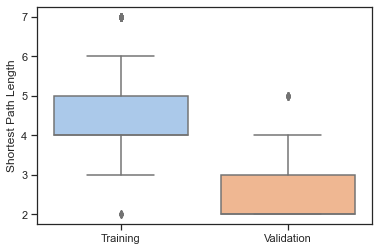

In [331]:
sns.boxplot(x="", y="Shortest Path Length", data=df)

## Illustration of Shortest Path

In [8]:
from IPython.display import SVG

import numpy as np
from scipy import sparse
import pandas as pd

import sknetwork.utils as utils
from sknetwork.utils import edgelist2adjacency, edgelist2biadjacency
from sknetwork.data import convert_edge_list, load_edge_list
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph

In [39]:
while True:
    edge = (random.choice(list(KG.nodes)), random.choice(list(KG.nodes)))
    if nx.astar_path_length(KG, edge[0], edge[1])==3:
        initial_list = nx.astar_path(KG, edge[0], edge[1])
        print(initial_list)
        break

['C0836924', 'C0026691', 'C0027361', 'C0679693']


In [75]:
add_nodes = [
    random.sample(
        list(KG.neighbors(i)),
        min(len(list(KG.neighbors(i))), 3)
    ) \
    for i in initial_list
]
add_nodes = list(itertools.chain(*add_nodes))
final_list = list(set(initial_list + add_nodes))
print(final_list)

['C0679693', 'C1397014', 'C1415068', 'C0040300', 'C0035648', 'C0015230', 'C0012634', 'C0008059', 'C1550661', 'C0027361', 'C0836924', 'C0026691']


In [12]:
# final_list = ['C0679693', 'C1397014', 'C1415068', 'C0040300', 'C0035648', 'C0015230', 'C0012634', 'C0008059', 'C1550661', 'C0027361', 'C0836924', 'C0026691']
C = KG.subgraph(final_list)

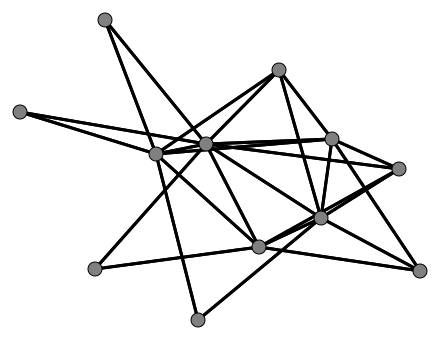

In [27]:
adjacency = nx.adjacency_matrix(C).todense()
adjacency = sparse.csr_matrix(adjacency)

# path = initial_list
# edge_labels = [
#     (
#         list(C).index(path[k]),
#         list(C).index(path[k + 1]),
#         0
#     ) for k in range(len(path) - 1)
# ]

# image = svg_graph(
#     adjacency,
#     names = final_list,
#     edge_labels=edge_labels,
#     edge_width=3,
#     display_edge_weight=False
# )

image = svg_graph(
    adjacency,
    edge_width=3,
    display_edge_weight=False
)

SVG(image)